In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.express as px

In [2]:
# Data Preparation
file_path = "/Users/ashikurrahmanshihab/GitHub/Hybrid-Demand-Forecasting-and-Reorder-Point-Planning-Using-AROPHET/Sales_Data_DiplomaInsFullCreMilkPowderBox400gm.xlsx"

try:
    sales_data = pd.read_excel(file_path)
    print("Sales data loaded successfully.")
except FileNotFoundError:
    print("File not found. Please check the file path.")
    sales_data = pd.DataFrame()
except Exception as e:
    print(f"Error loading file: {e}")
    sales_data = pd.DataFrame()

# --- Preview Raw Data ---
if not sales_data.empty:
    print("\n First 5 rows of raw data:")
    display(sales_data.head())
else:
    print("\n No data to display.")

Sales data loaded successfully.

 First 5 rows of raw data:


,ds,y,Sold Value,Average Lead Time,Avg Order Frequncey,Monthly Order Qty,safety stock,Shelf Life
0,2023-01-31,400,83105.00,7 Days,4,525,95,15 Month
1,2023-02-28,450,93492.00,7 Days,4,520,85,15 Month
2,2023-03-31,420,87259.20,7 Days,4,500,90,15 Month
3,2023-04-30,388,80610.88,7 Days,4,460,82,15 Month
4,2023-05-31,377,78325.52,7 Days,4,400,28,15 Month


In [3]:
# --- Standardize column names ---
sales_data.columns = sales_data.columns.str.strip()

required_cols = ['ds', 'y', 'Sold Value', 'Average Lead Time', 'Avg Order Frequncey', 'Monthly Order Qty', 'safety stock', 'Shelf Life']
missing_cols = [col for col in required_cols if col not in sales_data.columns]

if missing_cols:
    raise ValueError(f"Missing required columns in sales_data: {missing_cols}")

# --- Initialize Prophet ---
m = Prophet()

# --- Fit the model ---
m.fit(sales_data[['ds', 'y']])


18:26:20 - cmdstanpy - INFO - Chain [1] start processing
18:26:20 - cmdstanpy - INFO - Chain [1] done processing


In [4]:
# --- Clean Separate Basic Forecast Data ---
df_raw = pd.read_excel(file_path)

if df_raw.iloc[0, 0] == "Month":
    df_clean = df_raw.iloc[1:].reset_index(drop=True)
else:
    df_clean = df_raw.copy()

df_clean = df_clean.iloc[:, :2]
df_clean.columns = ['ds', 'y']

df_clean['y'] = (
    df_clean['y']
    .astype(str)
    .str.replace(r'[^0-9.]', '', regex=True)
    .replace('', pd.NA)
    .astype(float))

df_clean['ds'] = pd.to_datetime(df_clean['ds'], errors='coerce')
df_clean.dropna(inplace=True)

In [5]:
# Using 365 days initial training, 90 days step, 180 days forecast horizon
df_cv = cross_validation(
    m,
    initial='365 days',     # 1 year for training
    period='90 days',       # Advance by 3 months each fold
    horizon='180 days',     # Forecast 6 months ahead
    parallel="processes"
)

# --- Calculate Performance Metrics ---
df_p = performance_metrics(df_cv)

# --- Display Metrics ---
print("\nAvailable metrics:")
print(df_p.columns.tolist())

print("\nForecast Accuracy (average across folds):")
print(df_p[['horizon', 'mae', 'rmse', 'mape', 'coverage']])

# --- Calculate R² per Fold ---
r2_per_fold = df_cv.groupby('cutoff').apply(
    lambda fold: r2_score(fold['y'], fold['yhat'])
)

print("\nR² per fold:")
print(r2_per_fold)
print(f"\nMean R² across folds: {r2_per_fold.mean():.4f}")


Available metrics:
['horizon', 'mse', 'rmse', 'mae', 'mape', 'mdape', 'smape', 'coverage']

Forecast Accuracy (average across folds):
    horizon        mae       rmse      mape  coverage
0   25 days  33.627909  33.627909  0.075568       1.0
1   27 days  28.676429  28.676429  0.061274       1.0
2   56 days  39.033415  39.033415  0.086357       1.0
3   58 days  36.285925  36.285925  0.075753       1.0
4   86 days  40.490356  40.490356  0.088990       1.0
5   88 days  54.004792  54.004792  0.108010       0.0
6  117 days  51.895862  51.895862  0.110889       0.0
7  119 days  32.614288  32.614288  0.067664       1.0
8  148 days  61.301367  61.301367  0.127978       0.0
9  149 days  39.333155  39.333155  0.079945       0.0
10 178 days  80.758308  80.758308  0.161517       0.0
11 180 days  35.942651  35.942651  0.073054       1.0

R² per fold:
cutoff
2024-04-05    -7.279480
2024-07-04   -12.666189
dtype: float64

Mean R² across folds: -9.9728


18:26:21 - cmdstanpy - INFO - Chain [1] start processing
18:26:21 - cmdstanpy - INFO - Chain [1] start processing
18:26:21 - cmdstanpy - INFO - Chain [1] done processing
18:26:21 - cmdstanpy - INFO - Chain [1] done processing


18:26:21 - cmdstanpy - INFO - Chain [1] start processing
18:26:28 - cmdstanpy - INFO - Chain [1] done processing


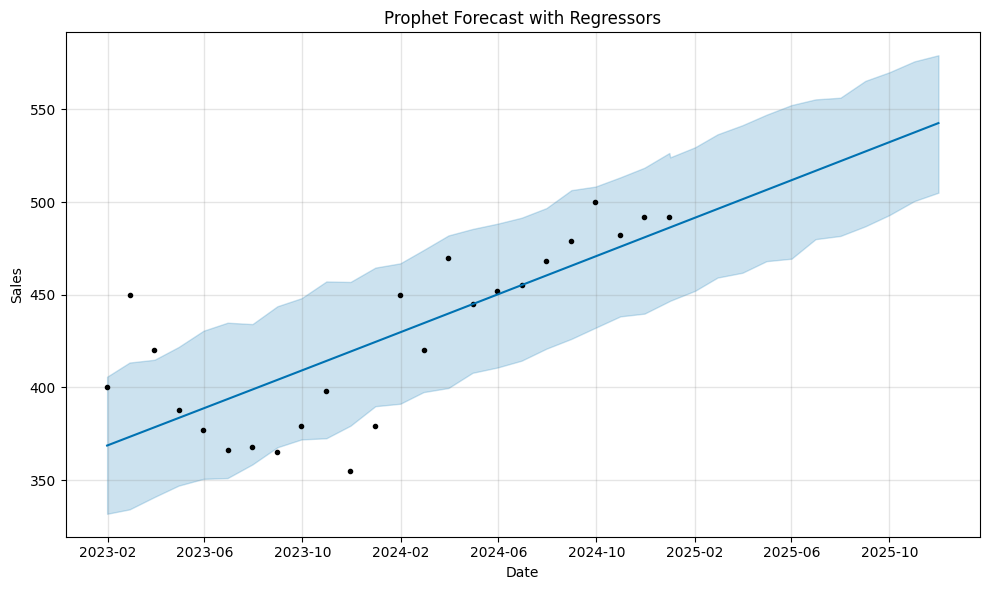

In [6]:
# Forecasting with Prophet
model = Prophet(yearly_seasonality=True)
model.fit(df_clean)

# --- Forecast 12 Future Months ---
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

# --- Extract 2025 Forecast ---
forecast_2025 = forecast[forecast['ds'].dt.year == 2025].copy()

# --- Define regressors ---
regressors = ['Sold Value', 'Average Lead Time', 'Avg Order Frequncey', 'Monthly Order Qty', 'safety stock', 'Shelf Life']

# --- Merge existing regressors into the future dataframe ---
# Ensure regressors exist in sales_data, otherwise fill with NaN
for reg in regressors:
    if reg not in sales_data.columns:
        sales_data[reg] = np.nan
future = pd.merge(future, sales_data[['ds'] + regressors], on='ds', how='left')

# --- Interpolate missing regressor values ---
for col in regressors:
    future[col] = future[col].interpolate(method='linear', limit_direction='forward')

# Optional: Fill any remaining NaNs (e.g., trailing values after interpolation)
future[regressors] = future[regressors].fillna(method='ffill')

# --- Forecast with Prophet ---
forecast = m.predict(future)

# --- Plot the forecast ---
fig = m.plot(forecast)
plt.title("Prophet Forecast with Regressors")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

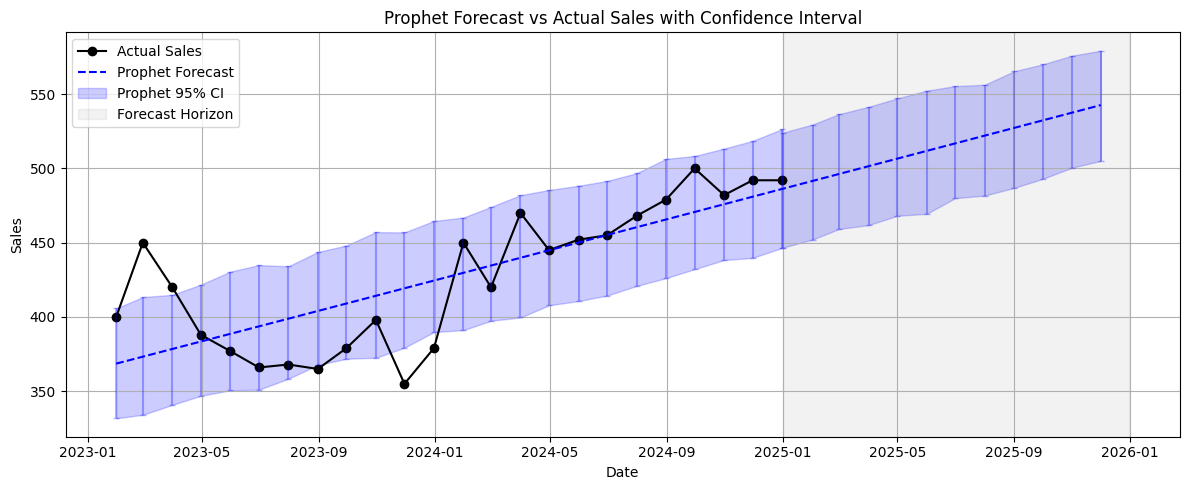

In [7]:
# --- Plot Setup ---
fig, ax = plt.subplots(figsize=(12, 5))

# --- Plot Actual Sales ---
ax.plot(
    df_clean['ds'],
    df_clean['y'],
    label='Actual Sales',
    marker='o',
    color='black',
    linewidth=1.5
)

# --- Prophet Forecast Line ---
ax.plot(
    forecast['ds'],
    forecast['yhat'],
    label='Prophet Forecast',
    linestyle='--',
    color='blue',
    linewidth=1.5
)

# --- Prophet Confidence Interval Shading ---
ax.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='blue',
    alpha=0.2,
    label='Prophet 95% CI'
)

# --- Prophet Error Bars ---
ax.errorbar(
    forecast['ds'],
    forecast['yhat'],
    yerr=[
        forecast['yhat'] - forecast['yhat_lower'],
        forecast['yhat_upper'] - forecast['yhat']
    ],
    fmt='none',
    ecolor='blue',
    alpha=0.3,
    capsize=2
)

# --- Highlight Forecast Region (2025) ---
ax.axvspan(
    pd.Timestamp('2025-01-01'),
    pd.Timestamp('2025-12-31'),
    color='gray',
    alpha=0.1,
    label='Forecast Horizon'
)

# --- Final Plot Details ---
ax.set_title('Prophet Forecast vs Actual Sales with Confidence Interval')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

In [8]:
# Bootstrapped Confidence Intervals for Prophet Forecast ---
df_with_yhat = pd.merge(df_clean, forecast[['ds', 'yhat']], on='ds')
df_with_yhat['residual'] = df_with_yhat['y'] - df_with_yhat['yhat']
residuals = df_with_yhat['residual'].values

n_boot = 1000
forecast_horizon = forecast_2025.shape[0]
boot_samples = np.empty((n_boot, forecast_horizon))

for i in range(n_boot):
    sampled_residuals = np.random.choice(residuals, size=forecast_horizon, replace=True)
    boot_samples[i] = forecast_2025['yhat'].values + sampled_residuals

forecast_2025['boot_lower'] = np.percentile(boot_samples, 2.5, axis=0)
forecast_2025['boot_upper'] = np.percentile(boot_samples, 97.5, axis=0)
forecast_2025['boot_median'] = np.percentile(boot_samples, 50, axis=0)

# Simulate Bootstrap Samples (based on boot_median) ---
np.random.seed(42)
boot_samples = pd.DataFrame(
    np.random.normal(loc=forecast_2025['boot_median'], scale=50, size=(1000, 12)).T,
    columns=[f'bs_{i}' for i in range(1000)])


 Reorder Point (ROP) Table:
           ds         yhat  boot_median   boot_upper  prophet_rop
24 2025-01-01   421.385353   423.283219   498.113053        498.0
25 2025-02-01  1064.853548  1069.388148  1141.581248       1142.0
26 2025-03-01   489.207543   493.742143   565.935243        566.0
27 2025-04-01   637.642129   639.539995   714.369829        714.0
28 2025-05-01   645.812051   650.346651   722.539751        723.0
29 2025-06-01   676.798744   681.333344   753.526444        754.0
30 2025-07-01   683.374667   685.272533   760.102367        760.0
31 2025-08-01   692.662820   694.560686   769.390520        769.0
32 2025-09-01   702.807800   704.705666   779.535500        780.0
33 2025-10-01   719.312622   721.210488   796.040322        796.0
34 2025-11-01   648.916019   650.813885   725.643719        726.0
35 2025-12-01   695.778972   700.313572   772.506672        773.0


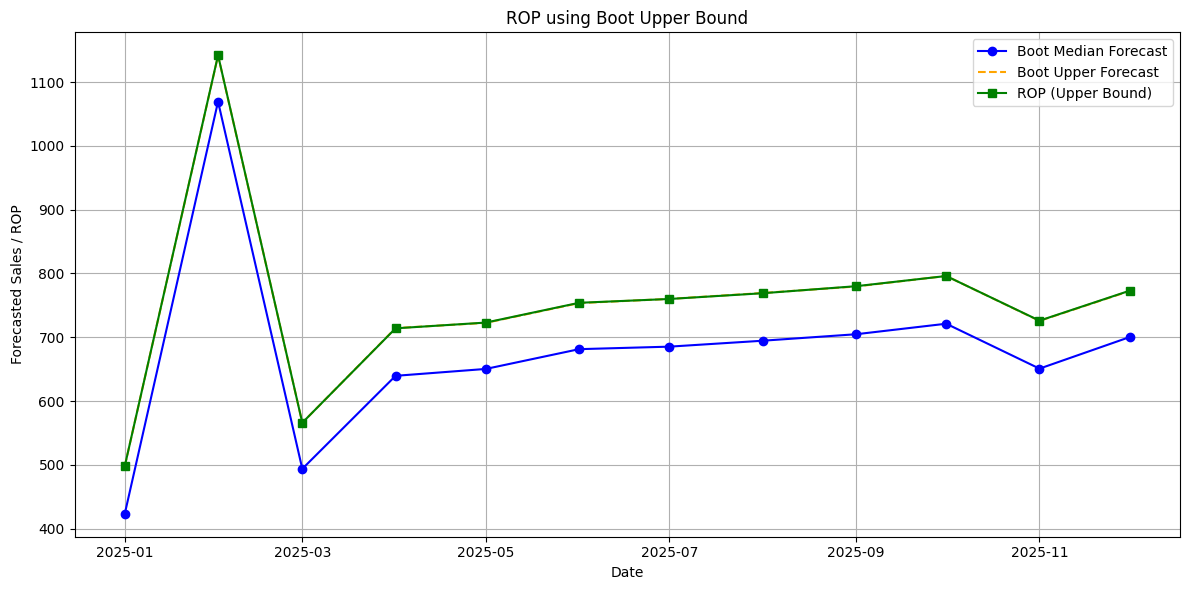

In [9]:
# Dynamic Reorder Point (ROP) Calculation
k = 1.0 
forecast_2025['prophet_rop'] = (forecast_2025['boot_median'] + k * (forecast_2025['boot_upper'] - forecast_2025['boot_median'])
).round().clip(lower=0)

# Output Table 
print("\n Reorder Point (ROP) Table:")
print(forecast_2025[['ds', 'yhat', 'boot_median', 'boot_upper', 'prophet_rop']])

# Plot 1: Prophet ROP based on upper bound ---
plt.figure(figsize=(12, 6))
plt.plot(forecast_2025['ds'], forecast_2025['boot_median'], label='Boot Median Forecast', marker='o', color='blue')
plt.plot(forecast_2025['ds'], forecast_2025['boot_upper'], label='Boot Upper Forecast', linestyle='--', color='orange')
plt.plot(forecast_2025['ds'], forecast_2025['prophet_rop'], label='ROP (Upper Bound)', marker='s', color='green')
plt.title("ROP using Boot Upper Bound")
plt.xlabel("Date")
plt.ylabel("Forecasted Sales / ROP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Residual Modeling with ARIMA
df_with_yhat = df_clean.merge(forecast[['ds', 'yhat']], on='ds', how='left')
df_with_yhat['residual'] = df_with_yhat['y'] - df_with_yhat['yhat']

arima_model = ARIMA(df_with_yhat['residual'].dropna(), order=(1, 0, 1)).fit()

arima_forecast = arima_model.forecast(steps=12)
final_forecast = forecast.tail(12).copy()
final_forecast['arima_correction'] = arima_forecast.values
final_forecast['yhat_hybrid'] = final_forecast['yhat'] + final_forecast['arima_correction']

merged_df = df_clean.merge(forecast[['ds', 'yhat']], on='ds', how='inner')
actual = merged_df['y'].values
prophet_pred = merged_df['yhat'].values

arima_correction_hist = arima_model.predict(start=0, end=len(actual) - 1)
arophet_pred = prophet_pred + arima_correction_hist


2025 Forecast and ROP Table:
           ds        yhat  arima_correction  yhat_hybrid  arophet_rop
0  2025-01-01  486.327059          5.089529   491.416588   473.527154
1  2025-02-01  491.550188          4.356157   495.906345   478.016911
2  2025-03-01  496.267853          3.866541   500.134394   482.244960
3  2025-04-01  501.490981          3.539663   505.030644   487.141210
4  2025-05-01  506.545622          3.321431   509.867053   491.977619
5  2025-06-01  511.768751          3.175735   514.944485   497.055051
6  2025-07-01  516.823391          3.078465   519.901856   502.012422
7  2025-08-01  522.046520          3.013525   525.060045   507.170611
8  2025-09-01  527.269649          2.970169   530.239818   512.350384
9  2025-10-01  532.324290          2.941224   535.265514   517.376080
10 2025-11-01  537.547418          2.921900   540.469318   522.579884
11 2025-12-01  542.602059          2.908999   545.511058   527.621623


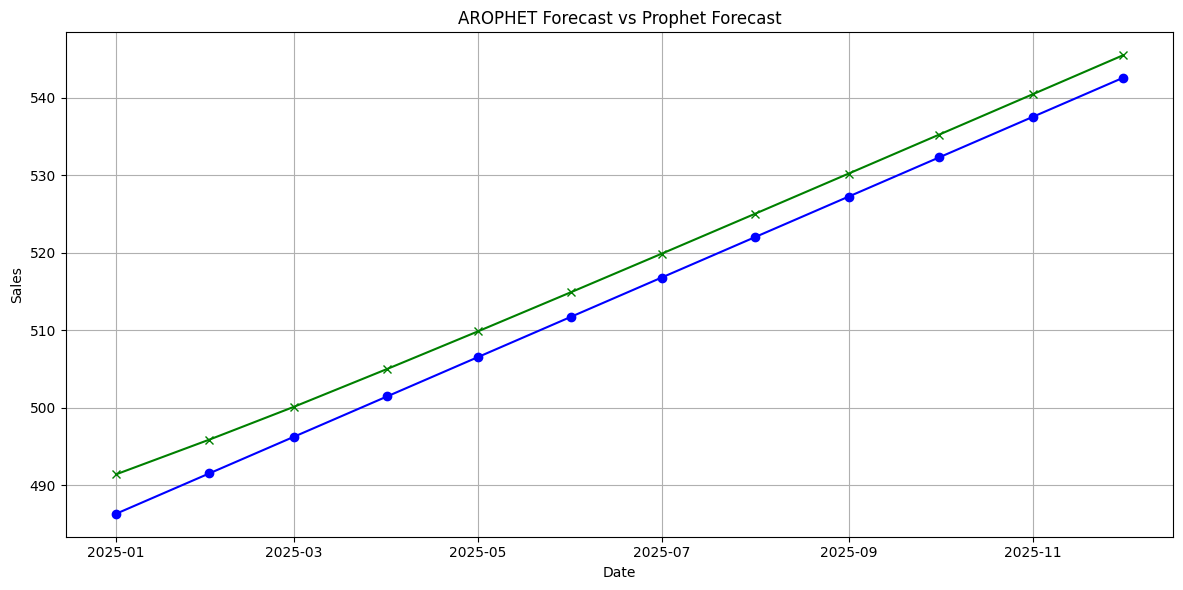

In [11]:
# Hybrid Forecast Using AROPHET
forecast_2025 = final_forecast[final_forecast['ds'].dt.year == 2025].copy()

if 'yhat_hybrid' in forecast_2025.columns:
    forecast_2025 = forecast_2025.drop(columns=['yhat_hybrid'])

forecast_2025 = forecast_2025.merge(
    final_forecast[['ds', 'yhat_hybrid']], on='ds', how='left')

# Final Dynamic ROP Using AROPHET
k = 1.0 
forecast_2025['prophet_rop'] = forecast_2025['yhat'] - k * (forecast_2025['yhat_upper'] - forecast_2025['yhat'])
hybrid_std = forecast_2025['yhat_hybrid'].std()
forecast_2025['arophet_median'] = forecast_2025['yhat_hybrid']
forecast_2025['arophet_rop'] = forecast_2025['yhat_hybrid'] - k * hybrid_std

# Output Table for AROPHET ROP
print("\n2025 Forecast and ROP Table:")
print(forecast_2025[['ds', 'yhat','arima_correction', 'yhat_hybrid', 'arophet_rop']])

plt.figure(figsize=(12, 6))
plt.title("AROPHET Forecast vs Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()      
plt.plot(forecast_2025['ds'], forecast_2025['yhat'], label='Prophet Forecast', marker='o', color='blue')
plt.plot(forecast_2025['ds'], forecast_2025['yhat_hybrid'], label='AROPHET Forecast', marker='x', color='green')                                         

In [12]:
# Forecast Accuracy Comparison
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

metrics = {
    'Model': ['Prophet', 'AROPHET'],
    'MAE': [
        mean_absolute_error(actual, prophet_pred),
        mean_absolute_error(actual, arophet_pred)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(actual, prophet_pred)),
        np.sqrt(mean_squared_error(actual, arophet_pred))
    ],
    'MAPE': [
        mape(actual, prophet_pred),
        mape(actual, arophet_pred)
    ],
    'R2': [
        r2_score(actual, prophet_pred),
        r2_score(actual, arophet_pred)
    ]
}
accuracy_df = pd.DataFrame(metrics)
print("Forecast Accuracy Metrics:")
print(accuracy_df)

Forecast Accuracy Metrics:
     Model        MAE       RMSE      MAPE        R2
0  Prophet  23.336806  30.410919  5.737078  0.576059
1  AROPHET  18.688320  24.623526  4.517284  0.722063


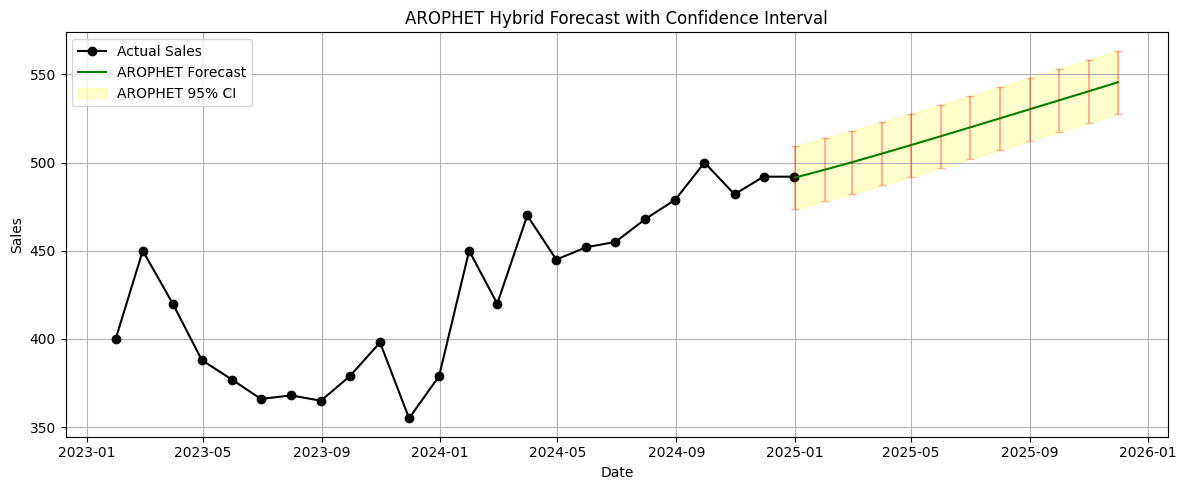

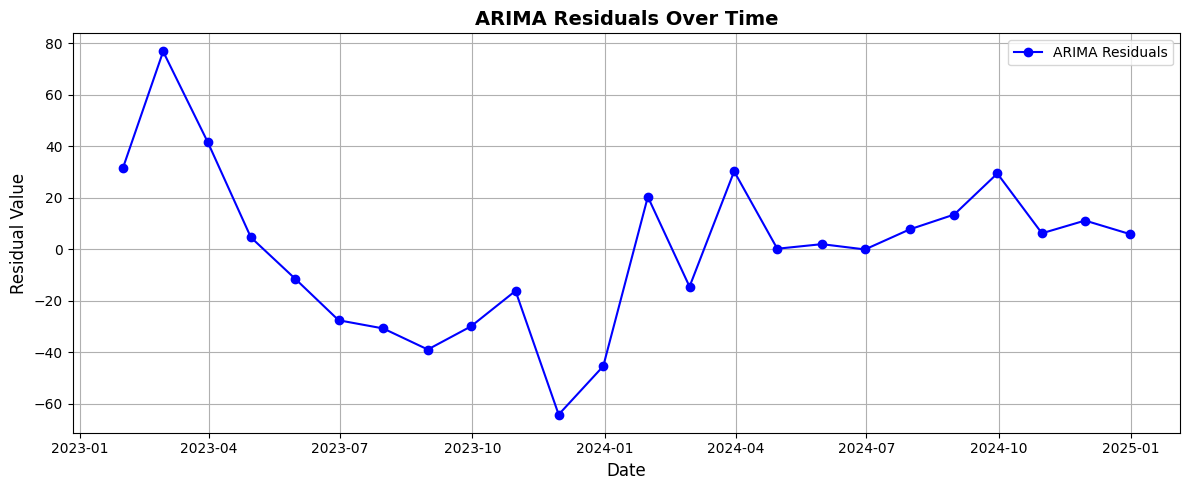

In [13]:
# Visualization of Forecast vs Actual Sales with Confidence Intervals
k = 1.0  # 95% confidence level
hybrid_std = forecast_2025['yhat_hybrid'].std()
forecast_2025['arophet_lower'] = forecast_2025['yhat_hybrid'] - k * hybrid_std
forecast_2025['arophet_upper'] = forecast_2025['yhat_hybrid'] + k * hybrid_std
plt.figure(figsize=(12, 5))
plt.plot(df_clean['ds'], df_clean['y'], label='Actual Sales', marker='o', color='black')
plt.plot(forecast_2025['ds'], forecast_2025['arophet_median'], label='AROPHET Forecast', linestyle='-', color='green')
if {'arophet_lower', 'arophet_upper'}.issubset(forecast_2025.columns): plt.fill_between(forecast_2025['ds'], forecast_2025['arophet_lower'], forecast_2025['arophet_upper'], color='yellow', alpha=0.2, label='AROPHET 95% CI')
plt.errorbar(forecast_2025['ds'], forecast_2025['arophet_median'], yerr=[forecast_2025['arophet_median'] - forecast_2025['arophet_lower'], forecast_2025['arophet_upper'] - forecast_2025['arophet_median']], fmt='none', ecolor='red', alpha=0.3, capsize=3)
plt.title('AROPHET Hybrid Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualization of Residual Value
plt.figure(figsize=(12, 5))
plt.plot(df_with_yhat['ds'], df_with_yhat['residual'], marker='o', linestyle='-', color='blue', label='ARIMA Residuals')
plt.title('ARIMA Residuals Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Residual Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

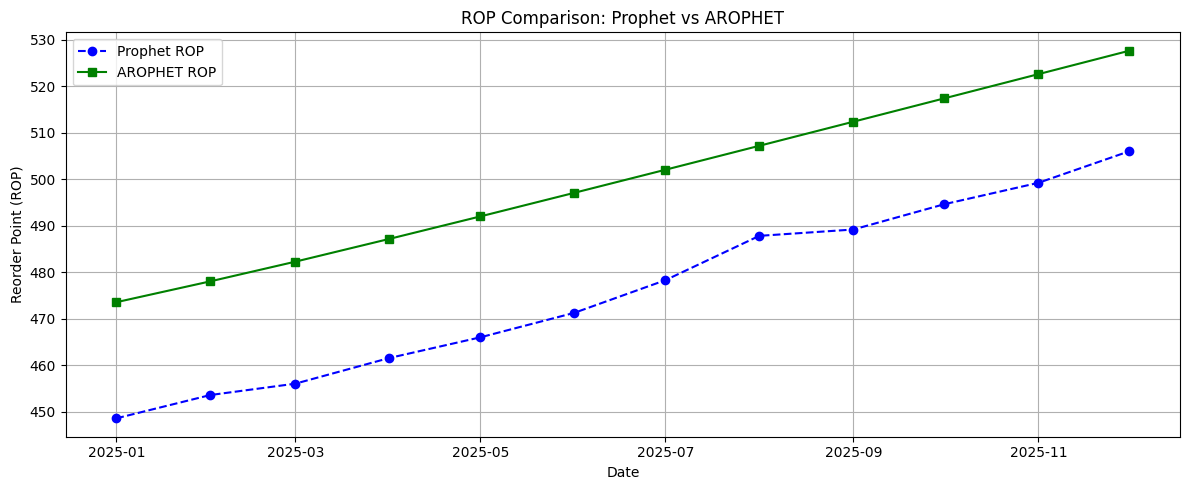

In [14]:
# ROP Comparision: (Prophet vs AROPHET)
plt.figure(figsize=(12, 5))
plt.plot(
    forecast_2025['ds'],
    forecast_2025['prophet_rop'],
    label='Prophet ROP',
    linestyle='--',
    marker='o',
    color='blue')

plt.plot(
    forecast_2025['ds'],
    forecast_2025['arophet_rop'],
    label='AROPHET ROP',
    linestyle='-',
    marker='s',
    color='green')

plt.title('ROP Comparison: Prophet vs AROPHET')
plt.xlabel('Date')
plt.ylabel('Reorder Point (ROP)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

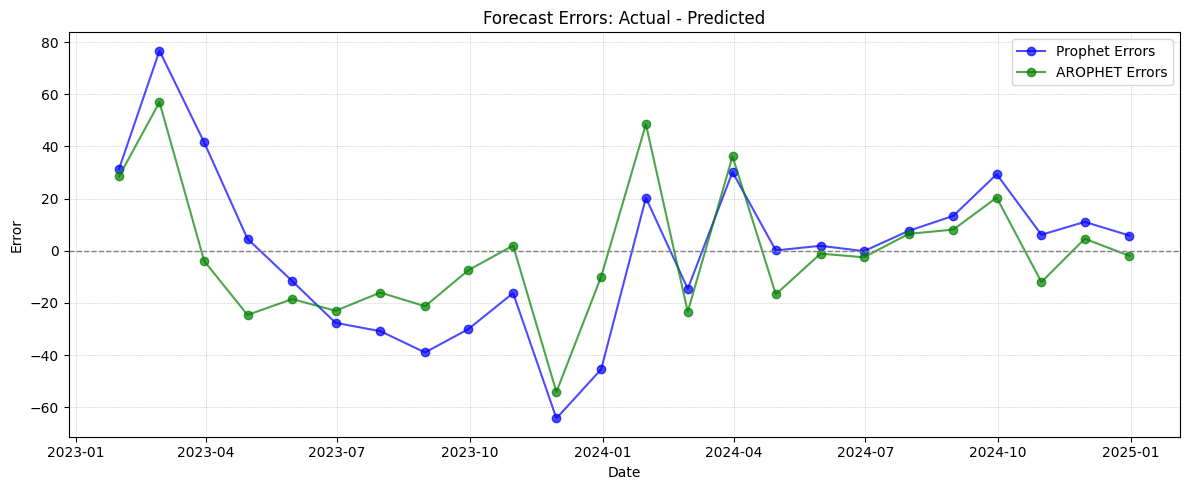

In [15]:
# Residuals Calculation
prophet_errors = actual - prophet_pred
arophet_errors = actual - arophet_pred

plt.figure(figsize=(12, 5))

# Prophet errors
plt.plot(
    df_clean['ds'],
    prophet_errors,
    label='Prophet Errors',
    marker='o',
    alpha=0.7,
    color='blue'
)

# AROPHET errors
plt.plot(
    df_clean['ds'],
    arophet_errors,
    label='AROPHET Errors',
    marker='o',
    alpha=0.7,
    color='green'
)

# Zero error reference line
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Final plot settings
plt.title('Forecast Errors: Actual - Predicted')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

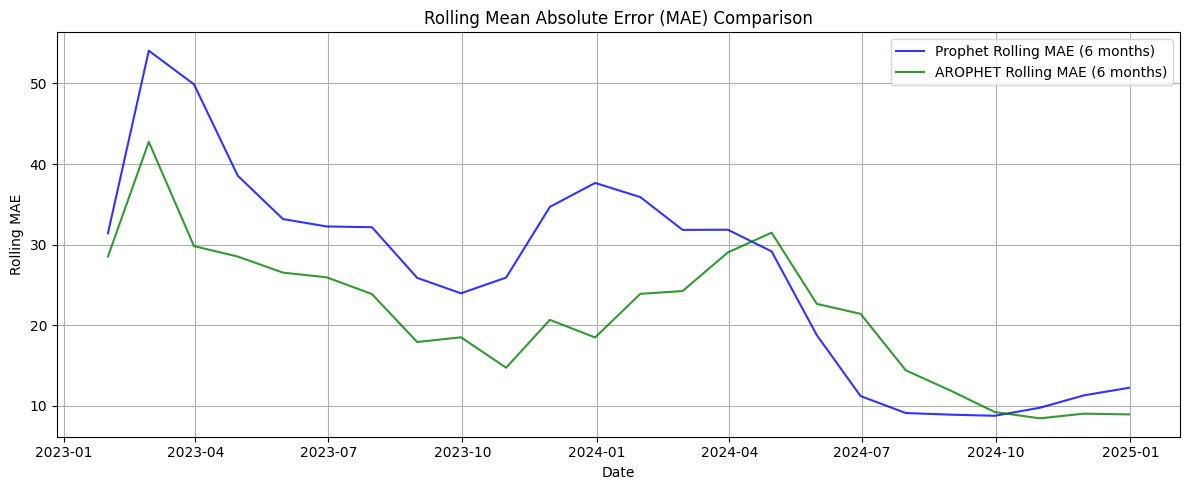

In [16]:
# Rolling Mean Absolute Error (MAE) Comparison
window = 6  # Rolling window size in months
rolling_mae_prophet = pd.Series(np.abs(prophet_errors)).rolling(window, min_periods=1).mean()
rolling_mae_arophet = pd.Series(np.abs(arophet_errors)).rolling(window, min_periods=1).mean()

plt.figure(figsize=(12, 5))

# Rolling MAE for Prophet
plt.plot(
    df_clean['ds'],
    rolling_mae_prophet,
    label=f'Prophet Rolling MAE ({window} months)',
    alpha=0.8,
    color='blue'
)

# Rolling MAE for AROPHET
plt.plot(
    df_clean['ds'],
    rolling_mae_arophet,
    label=f'AROPHET Rolling MAE ({window} months)',
    alpha=0.8,
    color='green'
)

# Final plot settings
plt.title('Rolling Mean Absolute Error (MAE) Comparison')
plt.xlabel('Date')
plt.ylabel('Rolling MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Here is a research-style explanation for your hybrid forecasting model (AROPHET):

---

Hybrid Demand Forecasting and Reorder Point Planning Using AROPHET
==================================================================

Overview:
---------
This model addresses the challenge of pharmaceutical sales forecasting and inventory management by combining two powerful time-series techniques: Prophet and ARIMA. The hybrid approach, named AROPHET, leverages the strengths of both models to deliver more accurate forecasts and robust inventory planning.

Model Structure:
----------------
- **Prophet** is used as the primary forecasting engine. It models trend, seasonality, and holiday effects in the sales data, providing baseline forecasts and uncertainty intervals.
- **ARIMA** is applied to the residuals (errors) from the Prophet model. By modeling these residuals, ARIMA captures autocorrelation and temporal patterns that Prophet may miss.
- The final forecast is a combination of Prophet’s predictions and ARIMA’s corrections, resulting in the AROPHET hybrid forecast.

Key Features:
-------------
- **Bootstrapped Confidence Intervals:** The model uses bootstrapping to generate more realistic confidence intervals for forecasts, improving uncertainty quantification.
- **Dynamic Reorder Point (ROP) Calculation:** Forecasts are used to calculate reorder points, ensuring optimal inventory levels and minimizing stockouts or overstock.
- **Rolling Error Analysis:** The model tracks rolling mean absolute error (MAE) to monitor forecast performance over time.

Advantages:
-----------
- **Improved Accuracy:** By correcting Prophet’s forecasts with ARIMA, the model reduces bias and error, as shown by lower MAE, RMSE, and MAPE, and higher R².
- **Better Uncertainty Estimation:** Bootstrapped intervals provide a more nuanced understanding of forecast risk, supporting better inventory decisions.
- **Practical Inventory Planning:** Accurate forecasts and ROP calculations help maintain medication availability while minimizing excess inventory costs.

Limitations:
------------
- The hybrid approach is more complex and computationally intensive than using Prophet alone.
- Requires careful residual analysis and ARIMA parameter selection.
- Assumes future external factors are similar to historical data.

Conclusion:
-----------
The AROPHET hybrid model is a robust solution for pharmaceutical sales forecasting and inventory management. By combining Prophet and ARIMA, it delivers superior accuracy and uncertainty estimation, enabling more effective and risk-aware supply chain decisions.

---

Let me know if you need a more technical breakdown or want to add specific implementation details!

- **Imports**: Loads libraries for data handling (`pandas`, `numpy`), visualization (`matplotlib`, `plotly`), forecasting (`Prophet`, `ARIMA`), and metrics.
- **Data Preparation**: Reads sales data from Excel, checks for required columns, and previews the data.
- **Prophet Model**: Fits a Prophet model to the sales data, performs cross-validation, and calculates performance metrics (MAE, RMSE, MAPE, R²).
- **Forecasting**: Forecasts future sales (12 months ahead), extracts 2025 forecasts, and merges regressor variables.
- **Visualization**: Plots actual vs. forecasted sales, including confidence intervals and error bars.
- **Bootstrapping**: Calculates bootstrapped confidence intervals for the forecast and simulates bootstrap samples.
- **ROP Calculation**: Computes dynamic reorder points (ROP) using bootstrapped upper bounds and visualizes the results.
- **Hybrid Model (AROPHET)**: Models residuals with ARIMA, applies corrections to Prophet forecasts, and calculates hybrid forecasts and ROPs.
- **Accuracy Comparison**: Compares Prophet and AROPHET models using MAE, RMSE, MAPE, and R².
- **Additional Visualizations**: Plots forecast errors, rolling MAE, and residuals for both models.



---

### 1. Importing Libraries
The notebook begins by importing essential Python libraries for data analysis, visualization, and forecasting:
- `numpy`, `pandas`: Data manipulation and analysis.
- `matplotlib`, `plotly`: Data visualization.
- `prophet`, `statsmodels.tsa.arima`: Time series forecasting models.
- `sklearn.metrics`: Model evaluation metrics.

---

### 2. Data Preparation
- The sales data is loaded from an Excel file.
- The code checks for the presence of required columns (e.g., date, sales, and various regressor variables).
- If the file is missing or columns are absent, appropriate error handling is performed.
- The first few rows of the data are displayed for inspection.

---

### 3. Data Cleaning
- Column names are standardized by stripping whitespace.
- The code ensures all required columns are present.
- The Prophet model is initialized and fitted using the date (`ds`) and sales (`y`) columns.

---

### 4. Basic Forecast Data Cleaning
- The raw data is further cleaned to ensure correct column names and types.
- Non-numeric characters are removed from the sales column.
- Dates are parsed and invalid entries are dropped.

---

### 5. Model Cross-Validation and Performance Metrics
- Prophet’s cross-validation is performed using a rolling window approach (365 days initial training, 90 days step, 180 days forecast horizon).
- Performance metrics (MAE, RMSE, MAPE, coverage) are calculated and displayed.
- R² scores are computed for each fold and averaged.

---

### 6. Forecasting with Prophet
- A Prophet model is fitted to the cleaned data.
- Future sales are forecasted for 12 months ahead.
- The forecast for the year 2025 is extracted.
- Regressor variables are merged into the future dataframe and missing values are interpolated.

---

### 7. Visualization of Prophet Forecast
- Actual sales and Prophet forecasts are plotted.
- Confidence intervals and error bars are included.
- The forecast region for 2025 is highlighted.

---

### 8. Bootstrapped Confidence Intervals
- Bootstrapping is used to estimate confidence intervals for the forecast.
- Residuals from the model are sampled to create bootstrapped forecasts.
- Lower, upper, and median bounds are calculated for the forecast.

---

### 9. Dynamic Reorder Point (ROP) Calculation
- ROP is calculated using the bootstrapped upper bound.
- The results are displayed in a table and visualized.

---

### 10. Residual Modeling with ARIMA
- Residuals from the Prophet model are modeled using ARIMA.
- ARIMA forecasts are added as corrections to the Prophet forecasts, creating a hybrid forecast (AROPHET).
- Historical corrections are applied to the Prophet predictions.

---

### 11. Hybrid Forecast Using AROPHET
- The hybrid forecast for 2025 is extracted.
- ROP is recalculated using the hybrid forecast.
- The results are displayed and visualized, comparing Prophet and AROPHET forecasts.

---

### 12. Forecast Accuracy Comparison
- MAE, RMSE, MAPE, and R² metrics are calculated for both Prophet and AROPHET models.
- Results are displayed in a table for comparison.

---

### 13. Visualization of Forecasts and Residuals
- Forecasts and confidence intervals are visualized.
- Residuals from the ARIMA model are plotted over time.

---

### 14. ROP Comparison
- ROP values from Prophet and AROPHET models are plotted for comparison.

---

### 15. Residuals Calculation and Visualization
- Errors (actual minus predicted) for both models are calculated and plotted.
- A reference line for zero error is included.

---

### 16. Rolling MAE Comparison
- Rolling mean absolute error (MAE) is calculated for both models using a 6-month window.
- Results are visualized to show error trends over time.